In [1]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
import sklearn
import scipy.stats
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from itertools import chain
from sklearn_crfsuite import CRF
from sklearn_crfsuite import scorers
from sklearn_crfsuite import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

### Load Data

In [24]:
def load_data(file_path):
    myoutput, words, tags = [],[],[]
    f = open(file_path)
    for line in f:
        #End of sentence
        if '\t' not in line:
            myoutput.append([words, tags])
            words, tags = [],[]
        else:
            out = line.split('\t')
            word = out[0]
            tag = out[1].replace('\n','')
            words.append(word.lower())
            tags.append(tag)
    f.close()
    return myoutput

In [3]:
load_data('datasets/recipes/bio/train.txt')

[[['how',
   'much',
   'flour',
   'will',
   'i',
   'need',
   'to',
   'fry',
   'easy',
   'passover',
   'lasagna',
   '?'],
  ['O',
   'O',
   'B-ING',
   'O',
   'O',
   'O',
   'O',
   'B-METHOD',
   'B-NAME',
   'I-NAME',
   'I-NAME',
   'O']],
 [['which', 'recipes', 'for', 'frying', 'small', 'zucchini', '?'],
  ['O', 'O', 'O', 'B-METHOD', 'B-ING', 'I-ING', 'O']],
 [['which', 'utensils', 'is', 'required', 'for', 'iced-teani', 'dish', '?'],
  ['O', 'O', 'O', 'O', 'O', 'B-NAME', 'O', 'O']],
 [['what',
   'are',
   'some',
   'good',
   'dishes',
   'that',
   'i',
   'can',
   'bake',
   'with',
   'sugar',
   ',',
   'butter',
   'and',
   'nectar',
   '?',
   '?'],
  ['O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'O',
   'B-METHOD',
   'O',
   'B-ING',
   'O',
   'B-ING',
   'O',
   'B-ING',
   'O',
   'O']],
 [['can',
   'you',
   'give',
   'me',
   'a',
   'recipe',
   'for',
   'vegetarian',
   'pumpkin',
   'chili',
   'with',
   'turkey',
   '?'],
  ['O',
   '

### Feature Engineering

In [25]:
def sen2fea(tokens):
    features = []
    tokens_lower = [token.lower() for token in tokens]
    token_tags = pos_tag(tokens_lower)
    for i,word in enumerate(tokens_lower):
        postag = token_tags[i][1]
        feature = {
            "bias": 1.0,
            "word.lower()": word.lower(),
            "word[-3:]": word[-3:],
            "word[-2:]": word[-2:],                        
            "word.isdigit()": word.isdigit(),
            "postag": postag,
            "postag[:2]": postag[:2],
        }
        if i > 0:
            word1 = tokens_lower[i-1]
            postag1 = token_tags[i-1][1]            
            feature.update({
                '-1:word.lower()': word1.lower(),                               
                '-1:word.isdigit()': word1.isdigit(),
                '-1:postag': postag1,
                '-1:postag[:2]': postag1[:2],                
            })
        else:
            feature['BOS'] = True
            
        if i < len(tokens)-1:
            word1 = tokens_lower[i+1]
            postag1 = token_tags[i+1][1]            
            feature.update({
                '+1:word.lower()': word1.lower(),                                
                '+1:word.isdigit()': word1.isdigit(),
                '+1:postag': postag1,
                '+1:postag[:2]': postag1[:2],                
            })
        else:
            feature['EOS'] = True
        features.append(feature)
    return features

In [26]:
def get_features(data):
    features = []
    labels = []
    for word_tag in data:
        features.append(sen2fea(word_tag[0]))
        labels.append(word_tag[1])
    return features, labels

In [5]:
train_path = "datasets/recipes/bio/train.txt"
test_path = "datasets/recipes/bio/test.txt"
X_train, y_train = get_features(load_data(train_path))
X_test, y_test = get_features(load_data(test_path))

## Training

In [7]:
crf = CRF(
    algorithm='lbfgs', 
    c1=0.1, 
    c2=0.1, 
    max_iterations=100, 
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

/home/naq/anaconda3/lib/python3.8/site-packages/sklearn/base.py:209: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  warnings.warn('From version 0.24, get_params will raise an '


CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=0.1,
    keep_tempfiles=None, max_iterations=100)

## Evaluation

In [10]:
labels = list(model.classes_)
labels

['O', 'B-ING', 'B-METHOD', 'B-NAME', 'I-NAME', 'I-ING', 'B-TYPE', 'I-TYPE']

In [9]:
y_pred = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred, average='weighted', labels=labels)

0.9923351287141323

In [11]:
sorted_labels = sorted(labels, key=lambda name: (name[1:], name[0]))
print(metrics.flat_classification_report(
    y_test, y_predict, labels=sorted_labels, digits=3
))

              precision    recall  f1-score   support

           O      0.994     1.000     0.997      2072
       B-ING      0.986     0.979     0.983       144
       I-ING      1.000     0.933     0.966        30
    B-METHOD      1.000     0.984     0.992       129
      B-NAME      0.985     0.981     0.983       270
      I-NAME      0.989     0.978     0.983       449
      B-TYPE      1.000     0.974     0.987        38
      I-TYPE      0.909     0.909     0.909        11

    accuracy                          0.992      3143
   macro avg      0.983     0.967     0.975      3143
weighted avg      0.992     0.992     0.992      3143



/home/naq/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:67: FutureWarning: Pass labels=['O', 'B-ING', 'I-ING', 'B-METHOD', 'B-NAME', 'I-NAME', 'B-TYPE', 'I-TYPE'] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


## Fine-tuning

In [22]:
# define fixed parameters and parameters to search
crf = CRF(
    algorithm='lbfgs', 
    max_iterations=100, 
    all_possible_transitions=True
)
params_space = {
    'c1': scipy.stats.expon(scale=0.5),
    'c2': scipy.stats.expon(scale=0.05),
}
# use the same metric for evaluation
f1_scorer = make_scorer(metrics.flat_f1_score, average='weighted', labels=labels)
# search
rs = RandomizedSearchCV(crf, params_space, 
                        cv=3, 
                        verbose=1, 
                        n_jobs=-1, 
                        n_iter=50,
                        scoring=f1_scorer)
rs.fit(X_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   25.0s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  1.2min finished


RandomizedSearchCV(cv=3,
                   estimator=CRF(algorithm='lbfgs',
                                 all_possible_transitions=True,
                                 keep_tempfiles=None, max_iterations=100),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'c1': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fceaad33730>,
                                        'c2': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fceaad33af0>},
                   scoring=make_scorer(flat_f1_score, average=weighted, labels=['O', 'B-ING', 'B-METHOD', 'B-NAME', 'I-NAME', 'I-ING', 'B-TYPE', 'I-TYPE']),
                   verbose=1)

In [23]:
print('best params:', rs.best_params_)
print('best CV score:', rs.best_score_)
print('model size: {:0.2f}M'.format(rs.best_estimator_.size_ / 1000000))

best params: {'c1': 0.022366261791697376, 'c2': 0.00040506311769517397}
best CV score: 0.9921050452295433
model size: 0.07M


## Check best estimator on our test data

In [13]:
# crf = rs.best_estimator_
# y_pred = crf.predict(X_test)
print(metrics.flat_f1_score(y_test, y_predict, average='weighted', labels=labels))
print(metrics.flat_classification_report(
    y_test, y_predict, labels=sorted_labels, digits=3
))

0.9923351287141323
              precision    recall  f1-score   support

           O      0.994     1.000     0.997      2072
       B-ING      0.986     0.979     0.983       144
       I-ING      1.000     0.933     0.966        30
    B-METHOD      1.000     0.984     0.992       129
      B-NAME      0.985     0.981     0.983       270
      I-NAME      0.989     0.978     0.983       449
      B-TYPE      1.000     0.974     0.987        38
      I-TYPE      0.909     0.909     0.909        11

    accuracy                          0.992      3143
   macro avg      0.983     0.967     0.975      3143
weighted avg      0.992     0.992     0.992      3143



## Confusion matrix

In [14]:
def print_cm(cm, labels):    
    matrix = []
    for i, label in enumerate(labels):
        row = []
        
        for j in range(len(labels)):            
            row.append(cm[i, j])            
        matrix.append(row)        
    conf_df = pd.DataFrame(matrix, index=labels, columns=labels)
    return conf_df

In [15]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as pt
def get_confusion_matrix(y_true,y_pred,labels):
    trues,preds = [], []
    for yseq_true, yseq_pred in zip(y_true, y_pred):
        trues.extend(yseq_true)
        preds.extend(yseq_pred)    
    return print_cm(confusion_matrix(trues,preds,labels),labels)

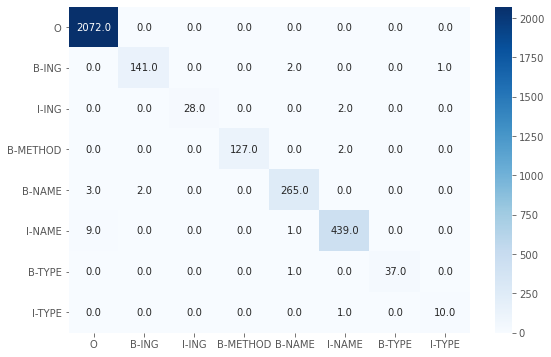

In [18]:
conf_df = get_confusion_matrix(y_test,y_predict, sorted_labels)
plt.figure(figsize = (9,6))
sn.heatmap(conf_df, annot=True, annot_kws={"size":10},fmt=".1f", cmap="Blues")
plt.show()

In [17]:
y_test

[['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'B-ING', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-ING', 'I-ING', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O', 'O', 'O'],
 ['O', 'O', 'B-ING', 'O', 'O', 'B-NAME', 'I-NAME', 'O'],
 ['O',
  'O',
  'B-ING',
  'O',
  'B-ING',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O',
  'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-ING', 'O', 'B-ING', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'O'],
 ['O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'O', 'O'],
 ['B-TYPE', 'O', 'O'],
 ['O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O'],
 ['O',
  'O',
  'O',
  'O',
  'O',
  'B

## Save model

In [2]:
import pickle
# pickle.dump(crf, open('model/crf_model.sav', 'wb'))

In [3]:
model = pickle.load(open('model/crf_model.sav', 'rb'))

In [8]:
model.predict([sen2fea(word_tokenize("Nutrition value: bacon rose Quiche?"))])

[['O', 'O', 'O', 'B-NAME', 'I-NAME', 'I-NAME', 'O']]

In [8]:
y_predict = model.predict(X_test)

In [6]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(model.transition_features_).most_common(10))

print("\nTop unlikely transitions:")
print_transitions(Counter(model.transition_features_).most_common()[-10:])

Top likely transitions:
B-NAME -> I-NAME  6.587744
I-NAME -> I-NAME  4.746244
B-ING  -> I-ING   4.473377
B-TYPE -> I-TYPE  3.747972
B-METHOD -> B-ING   2.343733
B-METHOD -> B-NAME  2.168351
O      -> O       1.984390
I-TYPE -> I-TYPE  1.848366
O      -> B-ING   1.804550
O      -> B-NAME  1.290636

Top unlikely transitions:
I-NAME -> I-TYPE  -1.079385
O      -> I-ING   -1.160358
I-NAME -> B-TYPE  -1.225808
B-METHOD -> B-METHOD -1.275061
O      -> I-TYPE  -1.309885
B-NAME -> B-NAME  -1.410243
B-TYPE -> I-NAME  -1.482959
I-NAME -> B-ING   -1.540808
B-METHOD -> I-NAME  -1.894658
O      -> I-NAME  -2.415369


In [31]:
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(model.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(model.state_features_).most_common()[-30:])

Top positive:
5.265810 O        word.lower():dish
4.635270 O        word.lower():preparing
4.459843 O        word.lower():cooking
4.433402 O        word.lower():making
4.106989 B-NAME   -1:word.lower():dish
3.978687 O        word.lower():make
3.734704 B-METHOD -1:word.lower():i
3.673913 O        bias
3.385860 B-TYPE   +1:word.lower():recipes
3.240072 O        word.lower():recipes
3.230918 B-ING    -1:word.lower():with
3.206765 B-METHOD word.lower():bake
3.088955 O        word.lower():recipe
3.088955 O        word[-3:]:ipe
3.088955 O        word[-2:]:pe
3.085869 B-TYPE   BOS
3.081948 O        word.lower():dishes
3.029161 O        +1:word.lower():of
2.828077 I-TYPE   +1:word.lower():recipes
2.723043 O        word.lower():ingredients
2.546475 B-ING    -1:word.lower():much
2.443577 O        word.lower():time
2.422887 B-TYPE   -1:word.lower():good
2.393360 O        word[-3:]:pes
2.284893 O        word[-3:]:ent
2.253986 B-METHOD word.lower():simmering
2.240939 B-METHOD word.lower():boiling
2

In [29]:
model.predict([sen2fea(word_tokenize('how long time to cook chiken'))])

[['O', 'O', 'O', 'O', 'O', 'B-NAME', 'I-NAME']]

In [5]:
model.transition_features_

{('O', 'O'): 1.98439,
 ('O', 'B-ING'): 1.80455,
 ('O', 'B-METHOD'): 1.280649,
 ('O', 'B-NAME'): 1.290636,
 ('O', 'I-NAME'): -2.415369,
 ('O', 'I-ING'): -1.160358,
 ('O', 'B-TYPE'): 1.042856,
 ('O', 'I-TYPE'): -1.309885,
 ('B-ING', 'O'): 0.973865,
 ('B-ING', 'B-ING'): -0.810269,
 ('B-ING', 'B-METHOD'): -0.066636,
 ('B-ING', 'B-NAME'): -0.801125,
 ('B-ING', 'I-NAME'): -0.848126,
 ('B-ING', 'I-ING'): 4.473377,
 ('B-ING', 'B-TYPE'): -0.185297,
 ('B-ING', 'I-TYPE'): -0.464669,
 ('B-METHOD', 'O'): 0.094777,
 ('B-METHOD', 'B-ING'): 2.343733,
 ('B-METHOD', 'B-METHOD'): -1.275061,
 ('B-METHOD', 'B-NAME'): 2.168351,
 ('B-METHOD', 'I-NAME'): -1.894658,
 ('B-METHOD', 'I-ING'): -0.187492,
 ('B-METHOD', 'B-TYPE'): -0.917467,
 ('B-METHOD', 'I-TYPE'): -0.009375,
 ('B-NAME', 'O'): -0.832444,
 ('B-NAME', 'B-ING'): -0.533399,
 ('B-NAME', 'B-METHOD'): -0.551533,
 ('B-NAME', 'B-NAME'): -1.410243,
 ('B-NAME', 'I-NAME'): 6.587744,
 ('B-NAME', 'I-ING'): -0.061735,
 ('B-NAME', 'B-TYPE'): -0.297711,
 ('B-NAME',